# Problem 2: Support Machines

# Part 1: Hard

In [1]:
from keras.datasets import mnist
from keras.utils import np_utils

(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
import numpy as np
# help from https://stackoverflow.com/questions/51202181/how-do-i-select-only-a-specific-digit-from-the-mnist-dataset-provided-by-keras
train_filter = np.where((train_y == 1) | (train_y == 7))
test_filter = np.where((test_y == 1) | (test_y == 7))

train_X, train_y = train_X[train_filter], train_y[train_filter]
test_X, test_y = test_X[test_filter], test_y[test_filter]

In [3]:
# help from Oliver Lu on reshaping
train_X = train_X.reshape(train_X.shape[0], 784)
test_X = test_X.reshape(test_X.shape[0], 784)

In [4]:
# help from https://dmkothari.github.io/Machine-Learning-Projects/SVM_with_MNIST.html
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# aiming for as close to infinity for C as possible
svm = SVC(kernel='linear',C=1e10).fit(train_X, train_y)
pred = svm.predict(test_X)
accuracy_score(test_y, pred)

0.9916782246879334

Hard margin classifier is pretty good, with over 99% accuracy!

# Part 2: Soft

In [5]:
# modified from lab 5
best_C = 0
best_score_test = 0
best_score_train = 0
linear_acc = 0

for this_C in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]:
    clf = SVC(kernel='linear',C=this_C).fit(train_X,train_y)
    score_test = clf.score(test_X,test_y)
    score_train = clf.score(train_X,train_y)
    pred = clf.predict(test_X)
    this_acc = accuracy_score(test_y, pred)
    if this_acc >= linear_acc:
      best_score_test = score_test
      best_score_train = score_train
      linear_acc = this_acc
      best_C = this_C

print("Best C value for soft margin: {}, test score: {:2f}, \
train score: {:2f}".format(best_C, best_score_test, best_score_train))

Best C value for soft margin: 5, test score: 0.991678, train score: 1.000000


# Part 3: Kernel

In [6]:
# modified from lab 5 
# some help from https://stackoverflow.com/questions/35655701/is-there-a-quicker-way-of-running-gridsearchcv
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [best_C], 'gamma':[.01,.05,.10,.25,.50,1]}
GS = GridSearchCV(SVC(kernel='rbf'),param_grid,cv=3,n_jobs=-1)
GS.fit(train_X[0:2000], train_y[0:2000])
# I stopped trying to fit the whole set after 40 min, smaller size helps
rbf_pred = GS.predict(test_X)
rbf_acc = accuracy_score(test_y, rbf_pred)

In [7]:
# suggested degrees>2 overfit here: https://en.wikipedia.org/wiki/Polynomial_kernel
# so going up to 6
param_grid = {'C': [best_C], 'degree':[1,2,3,4,5,6]}
GS2 = GridSearchCV(SVC(kernel='poly'),param_grid,cv=3,n_jobs=-1)
GS2.fit(train_X[0:2000], train_y[0:2000])
poly_pred = GS2.predict(test_X)
poly_acc = accuracy_score(test_y, poly_pred)

In [12]:
best_soft_svm_score = max(linear_acc, rbf_acc, poly_acc)
best_soft_svm = ""
kernel = ""
gamma = 0
degree = 0

if (best_soft_svm_score == linear_acc):
  best_soft_svm = "linear"
  kernel = "linear"
elif (best_soft_svm_score == rbf_acc):
  best_soft_svm = "rbf, gamma = {}".format(GS.best_params_['gamma'])
  kernel = "rbf"
  gamma = GS.best_params_['gamma']
else:
  best_soft_svm = "poly, degree = {}".format(GS2.best_params['degree'])
  kernel = "poly"
  degree = GS2.best_params['degree']

print("Best soft svm is {} with accuracy score: {:2f}".format(best_soft_svm, 
                                                          best_soft_svm_score))

Best soft svm is linear with accuracy score: 0.991678


# Part 4: AVA

In [9]:
from sklearn import metrics
# reset data
(train_X, train_y), (test_X, test_y) = mnist.load_data()

test_label = None
pred_label = None
digits = range(10)

In [10]:
for digit1 in digits:
  for digit2 in digits:
    if digit1 == digit2:
      continue
    
    # get datasets and clean
    train_filter = np.where((train_y == digit1) | (train_y == digit2))
    test_filter = np.where((test_y == digit1) | (test_y == digit2))
    x_train, y_train = train_X[train_filter], train_y[train_filter]
    x_test, y_test = test_X[test_filter], test_y[test_filter]
    x_train = x_train.reshape(x_train.shape[0], 784)
    x_test = x_test.reshape(x_test.shape[0], 784)

    # do modeling
    clf = SVC(kernel=kernel,C=best_C).fit(x_train[0:2000],y_train[0:2000])
    pred = clf.predict(x_test[0:2000])
    if pred_label is not None:
      pred_label = np.concatenate((pred_label, pred))
    else:
      pred_label = pred
    if test_label is not None:
      test_label = np.concatenate((test_label, y_test[0:2000]))
    else:
      test_label = y_test[0:2000]
    
    # print model scores
    train_score = clf.score(x_train[0:2000], y_train[0:2000])
    test_score = clf.score(x_test[0:2000], y_test[0:2000])
    print("For numbers {} and {}, train score: {:2f}, test_score: {:2f}".format(
        digit1, digit2, train_score, test_score))

For numbers 0 and 1, train score: 1.000000, test_score: 0.999000
For numbers 0 and 2, train score: 1.000000, test_score: 0.987500
For numbers 0 and 3, train score: 1.000000, test_score: 0.994472
For numbers 0 and 4, train score: 1.000000, test_score: 0.996942
For numbers 0 and 5, train score: 1.000000, test_score: 0.986645
For numbers 0 and 6, train score: 1.000000, test_score: 0.985552
For numbers 0 and 7, train score: 1.000000, test_score: 0.991000
For numbers 0 and 8, train score: 1.000000, test_score: 0.988741
For numbers 0 and 9, train score: 1.000000, test_score: 0.991453
For numbers 1 and 0, train score: 1.000000, test_score: 0.999000
For numbers 1 and 2, train score: 1.000000, test_score: 0.986500
For numbers 1 and 3, train score: 1.000000, test_score: 0.992500
For numbers 1 and 4, train score: 1.000000, test_score: 0.999000
For numbers 1 and 5, train score: 1.000000, test_score: 0.991000
For numbers 1 and 6, train score: 1.000000, test_score: 0.994000
For numbers 1 and 7, trai

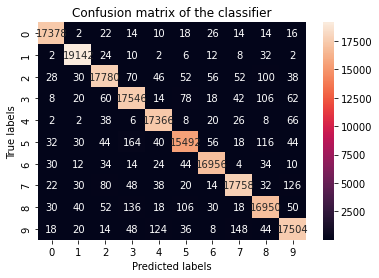

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(test_label, pred_label)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_title('Confusion matrix of the classifier')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()